## Target Hypothesis

1. Score both Main & Co as two seperate customers

bs = fit(bs)

ws = fit(ws)




2. Make a model of both with Co as a dummy


bs = xtrain (bs,ws)


2.1 

    ws input 0


    if 1 Applicant:

        bs = xtrain (bs,0)

    else:

        bs = xtrain (bs,ws)


2.2  --> could be adversed selection due to that having a co applicant might say something about the relasionship between the two

    ws - applications with co -applicant and for these take the mean 


    if 1 Applicant:

        bs = xtrain (bs,mean(ws))

    else:

        bs = xtrain (bs,ws)




3. Worst 

if main = main:

else:

    ws




4. Best --makes sence     1. Main -- Always main -->  2. CO --> best score 


if main = main:

else:

    bs



5. Test two seperate scorecards for main & co

5.1 

     main = main 

     Co --> Best 

5.2

     main = main 

     Co --> CO 




In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance




In [2]:

################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')


In [3]:
df

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-03-08,8205045,0,7711025523,2022-03-10,250000,1,1,0,1,...,50227.0,224.1,248.5,247.0,258.4,630444,81995,288551,519248,0
1,2022-04-07,8228347,0,9804048719,2022-04-22,400000,1,1,1,1,...,763.7,1333.3,1553.4,2678645.0,241491.0,1655157,2249127,0,0,0
2,2022-04-08,8229075,0,6501225061,2022-04-12,240000,1,1,0,1,...,85589.0,322.8,415.5,320.5,331.8,882268,279047,442904,685525,0
3,2022-04-11,8230481,0,9606236371,2022-04-13,295000,1,1,0,1,...,268.0,476.0,439.5,883993.0,100348.0,452428,627919,0,0,0
4,2022-04-15,8233936,0,8602147608,2022-06-08,270000,1,1,0,1,...,379.3,1362741.0,251386.0,547363.0,971946.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,2023-04-28,8660675,0,8902289209,2023-05-31,271000,1,1,1,0,...,195.3,381102.0,84024.0,274075.0,312523.0,0,0,0,0,0
3489,2023-04-28,8660675,0,8903213695,2023-05-31,271000,0,2,1,0,...,121.2,348937.0,91087.0,215240.0,265065.0,0,0,0,0,0
3490,2023-04-28,8660600,0,8007075586,2023-05-08,350000,1,1,1,0,...,40754.0,165.3,135.9,130.5,145.1,509094,147353,245526,367844,0
3491,2023-04-28,8660600,0,8203014934,2023-05-08,350000,0,2,1,0,...,38839.0,96.0,76.7,72.3,92.7,487593,113811,198074,353883,0


In [4]:
# pd.set_option('display.max_columns', None)

# git add .

# git commit -m "Finalised API Loop"

#  git status

#  git push origin Andreas

In [5]:
df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge'])

base = df.drop(columns=['HasCoapp'])




In [6]:
base

,Ever90,avg_CashWithdrawal,avg_Crypto,avg_DebtCollection,avg_Deposit,avg_DirectDebit,avg_Gambling,avg_Gaming,avg_HousingCost,avg_InstallmentPayment,...,Unclassified_partOfSalary6Months,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors
0,1,0,0,1017,1243,0,11,21,887,8444,...,770.0,50227.0,224.1,248.5,247.0,258.4,630444,81995,288551,519248
1,1,1717,0,899,3788,0,99403,1615,0,14614,...,1330.7,763.7,1333.3,1553.4,2678645.0,241491.0,1655157,2249127,0,0
2,1,7757,0,1614,18338,0,845,0,0,8678,...,841.0,85589.0,322.8,415.5,320.5,331.8,882268,279047,442904,685525
3,1,2885,0,956,1502,0,896,38,644,14717,...,446.6,268.0,476.0,439.5,883993.0,100348.0,452428,627919,0,0
4,1,2,0,2337,1063,0,1701,43,3178,9537,...,318.5,379.3,1362741.0,251386.0,547363.0,971946.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,0,1297,0,2293,3276,0,0,19,2284,5349,...,241.9,195.3,381102.0,84024.0,274075.0,312523.0,0,0,0,0
3489,0,1142,0,14629,1435,0,0,29,1750,5358,...,155.3,121.2,348937.0,91087.0,215240.0,265065.0,0,0,0,0
3490,0,25,0,3304,1649,0,0,44,0,8888,...,640.0,40754.0,165.3,135.9,130.5,145.1,509094,147353,245526,367844
3491,0,0,0,0,986,742,261,33,0,22999,...,505.0,38839.0,96.0,76.7,72.3,92.7,487593,113811,198074,353883


In [7]:
forforsta = base.iloc[:,:50]

[I 2024-05-21 16:30:03,440] A new study created in memory with name: no-name-edd3af5a-d1d6-4a44-86fb-9e78497ecf0c
[I 2024-05-21 16:30:03,440] A new study created in memory with name: no-name-3f3d5a43-84ba-4c7a-b90f-4428c76117f5
[I 2024-05-21 16:30:03,440] A new study created in memory with name: no-name-926c5d82-d75d-4719-b944-5ca338639148
[I 2024-05-21 16:30:03,440] A new study created in memory with name: no-name-4a31b9db-cc56-4cdc-9727-fe012624a63e
[I 2024-05-21 16:30:03,466] Trial 0 finished with value: 0.11062883644471048 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.11062883644471048.


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Ever90
0    2230
1    2230
Name: count, dtype: int64
Optimizing naive_bayes...
Optimizing xgboost...
Optimizing random_forest...
Optimizing logistic_regression...


[I 2024-05-21 16:30:03,735] Trial 1 finished with value: 0.27304721943965915 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.034578589584109164, 'binarize': 0.24746364272846}. Best is trial 1 with value: 0.27304721943965915.
[I 2024-05-21 16:30:03,832] Trial 2 finished with value: 0.11062883644471048 and parameters: {'nb_type': 'gaussian'}. Best is trial 1 with value: 0.27304721943965915.
[I 2024-05-21 16:30:03,974] Trial 3 finished with value: 0.27323650692635315 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.3836496461017431, 'binarize': 0.013184673817106977}. Best is trial 3 with value: 0.27323650692635315.
[I 2024-05-21 16:30:04,074] Trial 4 finished with value: 0.2698064685001373 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.08726324128943726, 'binarize': 0.0025622181869043013}. Best is trial 3 with value: 0.27323650692635315.
[I 2024-05-21 16:30:04,117] Trial 5 finished with value: 0.11062883644471048 and parameters: {'nb_type': 'gaussian'}. Best is trial 3 with va

Early stopping triggered.
Best parameters for naive_bayes: {'nb_type': 'bernoulli', 'alpha': 0.05191947415077051, 'binarize': 0.024007041416884853}


[I 2024-05-21 16:30:04,883] Trial 0 finished with value: 0.9961097812008545 and parameters: {'n_estimators': 34, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9961097812008545.
[I 2024-05-21 16:30:05,278] Trial 1 finished with value: 0.9615743472228658 and parameters: {'n_estimators': 33, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9961097812008545.
[I 2024-05-21 16:30:05,509] Trial 0 finished with value: 0.9989169835717467 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.1709347569508691}. Best is trial 0 with value: 0.9989169835717467.
[I 2024-05-21 16:30:05,713] Trial 1 finished with value: 0.9901924953794327 and parameters: {'n_estimators': 46, 'max_depth': 5, 'learning_rate': 0.20903664180186612}. Best is trial 0 with value: 0.9989169835717467.
[I 2024-05-21 16:30:06,208] Trial 2 finished with value: 0.9962161542189735 and parameters: {'n_estimators': 71, 'max

Early stopping triggered.
Best parameters for xgboost: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.1709347569508691}


[I 2024-05-21 16:30:27,907] Trial 15 finished with value: 0.9978640067474661 and parameters: {'n_estimators': 184, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.998557625050049.
[I 2024-05-21 16:30:28,644] Trial 16 finished with value: 0.9988398288446046 and parameters: {'n_estimators': 53, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.9988398288446046.
[I 2024-05-21 16:30:29,345] Trial 17 finished with value: 0.9965966250294741 and parameters: {'n_estimators': 51, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.9988398288446046.
[I 2024-05-21 16:30:30,122] Trial 18 finished with value: 0.9972334380140572 and parameters: {'n_estimators': 56, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.9988398288446046.
[I 2024-05-21 16:30:31,972] Trial 19 finished with value: 0.9977809616154599 and paramet

Early stopping triggered.
Best parameters for random_forest: {'n_estimators': 53, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1}


[I 2024-05-21 16:30:32,570] Trial 4 finished with value: 0.267020710351857 and parameters: {'C': 13.339877457022462, 'solver': 'sag'}. Best is trial 2 with value: 0.27063641096323376.
[I 2024-05-21 16:30:39,481] Trial 5 finished with value: 0.26701226835800274 and parameters: {'C': 0.25047317312268275, 'solver': 'sag'}. Best is trial 2 with value: 0.27063641096323376.
[I 2024-05-21 16:30:46,351] Trial 6 finished with value: 0.26700382311785203 and parameters: {'C': 0.1314360435941256, 'solver': 'sag'}. Best is trial 2 with value: 0.27063641096323376.
[I 2024-05-21 16:30:46,441] Trial 7 finished with value: 0.27079560284734217 and parameters: {'C': 0.062489820113687075, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 7 with value: 0.27079560284734217.
[I 2024-05-21 16:30:46,522] Trial 8 finished with value: 0.27043630762842463 and parameters: {'C': 0.07323264834617446, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 7 with value: 0.27079560284734217.
[I

Early stopping triggered.
Best parameters for logistic_regression: {'C': 0.062489820113687075, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}


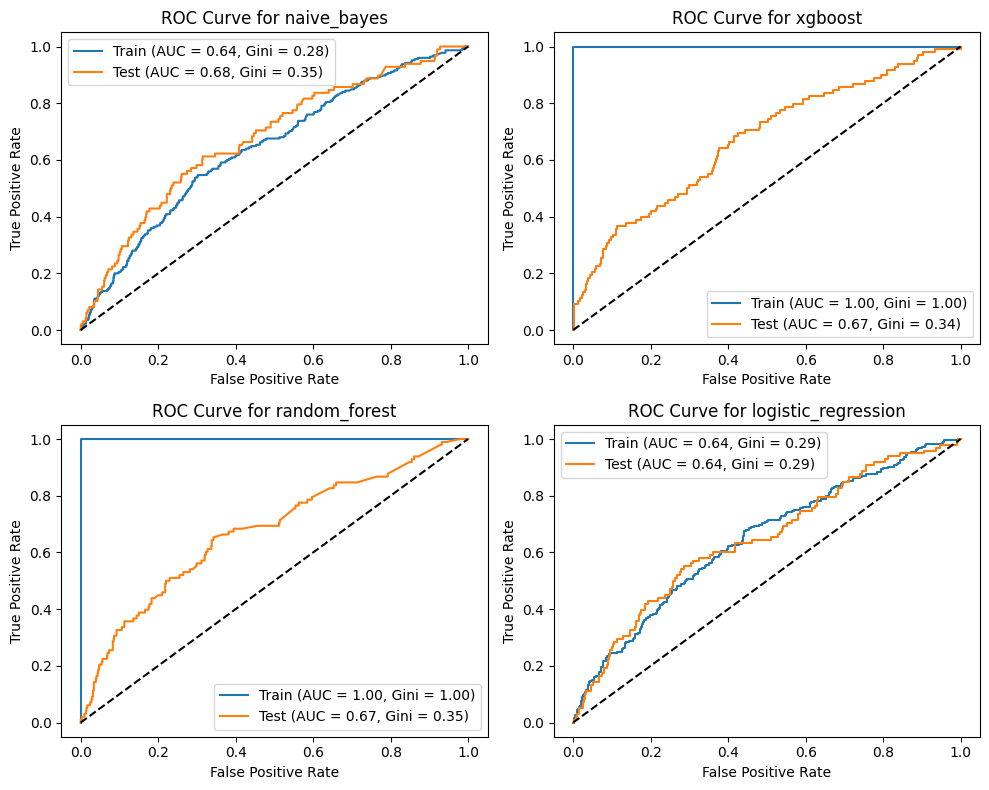

Features to keep: ['avg_CashWithdrawal', 'avg_Crypto', 'avg6Months_DirectDebit', 'avg6Months_Gambling', 'avg_Gaming', 'avg3Months_HousingCost', 'avg6Months_MobilePayment', 'avg_MoneyRemittance']
Features to discard: ['avg6Months_CashWithdrawal', 'avg6Months_Crypto', 'avg3Months_Crypto', 'avg3Months_DirectDebit', 'avg_DirectDebit', 'avg_Gambling', 'avg6Months_Gaming', 'avg3Months_Gaming', 'avg_HousingCost', 'avg6Months_HousingCost', 'avg3Months_MobilePayment', 'avg_MobilePayment', 'avg6Months_MoneyRemittance', 'avg3Months_MoneyRemittance']


In [8]:

preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled,  = preprocessor.get_split_data_with_upsample_and_scaling(0.7)

# Example usage
models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models=models, X_train=Xtrain, y_train=Ytrain, n_trials=100)
best_params, best_models = optimizer.run()

# Usage
# Assuming best_models, Xtrain, Ytrain, Xtest, Ytest, train_upsampled are predefined
evaluator = ModelEvaluator(Xtrain, Ytrain, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()


# Usage
# Assuming best_models, train_upsampled, and forforsta are predefined
feature_importance = FeatureImportance(train_upsampled, best_models, forforsta)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features = feature_importance.plot_importances()


## Filter away highly correlated features and take away the absolut worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
SelectionOne = filtered_list[:30]

## 

10 iterationer för 4 algoritmer tar 5 minuter

skulle vi göra 100 iterationer så är vi uppe i en timme,

gör vi detta för alla 250 features så har vi !250 * 50 minuter  detta hade varit bananas!


## Feature 50 - 100

In [31]:

# Keep the first feature (column)
first_feature = base.iloc[:, 0]

# Select columns from 50 to 100 (note: column index is 0-based, so 50-100 is 49-99)
selected_features = base.iloc[:, 49:100]

# Combine the first feature with the selected features
forforsta = pd.concat([first_feature, selected_features], axis=1)

forforsta

,Ever90,avg6Months_MoneyRemittance,avg6Months_OtherIncome,avg6Months_OtherSubsidies,avg6Months_PassiveIncome,avg6Months_Salary,avg6Months_Unclassified,count_CashWithdrawal,count_Crypto,count_DebtCollection,...,sum_Unclassified,trend_CashWithdrawal,trend_Crypto,trend_DebtCollection,trend_Deposit,trend_DirectDebit,trend_Gambling,trend_Gaming,trend_HousingCost,trend_InstallmentPayment
0,1,0,104,533,0,19471,0,1,0,16,...,0,0.0,0.0,86.0,0.0,0.0,0.0,100.0,90.6,-51.7
1,1,0,0,0,0,24828,0,20,0,6,...,0,34.6,0.0,-13.4,148.4,0.0,-78.0,-76.9,0.0,373.5
2,1,0,0,0,0,23030,0,86,0,16,...,0,-7.8,0.0,52.0,-55.9,0.0,3.1,0.0,0.0,-42.4
3,1,10,0,0,0,19008,0,42,0,20,...,0,-100.0,0.0,49.2,80.8,0.0,-43.0,902.0,0.0,-6.2
4,1,0,950,0,0,28640,0,1,0,26,...,0,0.0,0.0,73.3,-81.7,0.0,364.2,0.0,100.0,71.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,0,338,994,0,4923,13959,0,34,0,15,...,0,905.8,0.0,-100.0,11096.4,0.0,0.0,143.8,56.6,-37.2
3489,0,254,442,0,1938,22774,0,9,0,35,...,0,1260.0,0.0,-79.7,19313.7,0.0,0.0,0.0,-100.0,-49.1
3490,0,0,4480,0,0,31358,0,1,0,23,...,0,0.0,0.0,51.6,100.0,0.0,0.0,-100.0,0.0,20.4
3491,0,0,0,0,0,45633,0,0,0,0,...,0,0.0,0.0,0.0,370.9,47.4,-4.3,100.0,0.0,28.1


[I 2024-05-21 16:46:26,646] A new study created in memory with name: no-name-9327586d-19e4-4900-bad9-002d359319de
[I 2024-05-21 16:46:26,647] A new study created in memory with name: no-name-1e806ab3-c1da-48a1-8320-162035271dd3
[I 2024-05-21 16:46:26,647] A new study created in memory with name: no-name-f767892c-ef5c-480a-81f8-4c7adc7fd134
[I 2024-05-21 16:46:26,647] A new study created in memory with name: no-name-6fe2e190-ea9c-4624-8922-d2d2ef75af8c
[I 2024-05-21 16:46:26,724] Trial 0 finished with value: 0.3709733839986711 and parameters: {'C': 0.0991319794389189, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 0 with value: 0.3709733839986711.
[I 2024-05-21 16:46:26,786] Trial 0 finished with value: 0.27988536837131184 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.06633882510331483, 'binarize': 0.0013094245891711268}. Best is trial 0 with value: 0.27988536837131184.
[I 2024-05-21 16:46:26,813] Trial 1 finished with value: 0.13702889007742294 and parameters: {

Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Ever90
0    2230
1    2230
Name: count, dtype: int64
Optimizing naive_bayes...
Optimizing xgboost...
Optimizing random_forest...
Optimizing logistic_regression...


[I 2024-05-21 16:46:26,910] Trial 2 finished with value: 0.28290017951434904 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.15418034573562986, 'binarize': 0.003963983693729986}. Best is trial 2 with value: 0.28290017951434904.
[I 2024-05-21 16:46:26,932] Trial 3 finished with value: 0.13702889007742294 and parameters: {'nb_type': 'gaussian'}. Best is trial 2 with value: 0.28290017951434904.
[I 2024-05-21 16:46:26,980] Trial 4 finished with value: 0.13702889007742294 and parameters: {'nb_type': 'gaussian'}. Best is trial 2 with value: 0.28290017951434904.
[I 2024-05-21 16:46:27,008] Trial 5 finished with value: 0.13702889007742294 and parameters: {'nb_type': 'gaussian'}. Best is trial 2 with value: 0.28290017951434904.
[I 2024-05-21 16:46:27,023] Trial 6 finished with value: 0.13702889007742294 and parameters: {'nb_type': 'gaussian'}. Best is trial 2 with value: 0.28290017951434904.
[I 2024-05-21 16:46:27,078] Trial 7 finished with value: 0.27970105989176036 and parameters: {'nb_ty

Early stopping triggered.
Best parameters for naive_bayes: {'nb_type': 'bernoulli', 'alpha': 0.8443568220303826, 'binarize': 0.5303766934756537}


[I 2024-05-21 16:46:28,381] Trial 1 finished with value: 0.36974618006838805 and parameters: {'C': 0.08625423054529906, 'solver': 'sag'}. Best is trial 0 with value: 0.3709733839986711.
[I 2024-05-21 16:46:28,754] Trial 0 finished with value: 0.8648001812679983 and parameters: {'n_estimators': 171, 'max_depth': 4, 'learning_rate': 0.01946393725324719}. Best is trial 0 with value: 0.8648001812679983.
[I 2024-05-21 16:46:28,872] Trial 1 finished with value: 0.9983260667260258 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9983260667260258.
[I 2024-05-21 16:46:29,752] Trial 1 finished with value: 0.9925185803886002 and parameters: {'n_estimators': 53, 'max_depth': 9, 'learning_rate': 0.035474704203664616}. Best is trial 1 with value: 0.9925185803886002.
[I 2024-05-21 16:46:29,935] Trial 2 finished with value: 0.9984863688435116 and parameters: {'n_estimators': 79, 'max_depth': 13, 'min_samples_split': 10

Early stopping triggered.
Best parameters for logistic_regression: {'C': 0.35692895683952386, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}


[I 2024-05-21 16:46:39,058] Trial 6 finished with value: 0.9943976406411017 and parameters: {'n_estimators': 127, 'max_depth': 4, 'learning_rate': 0.21850165509904357}. Best is trial 4 with value: 0.9983164252256423.
[I 2024-05-21 16:46:39,956] Trial 8 finished with value: 0.9968017617468908 and parameters: {'n_estimators': 152, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.9985453735273394.
[I 2024-05-21 16:46:40,205] Trial 7 finished with value: 0.996933137740078 and parameters: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.0699087417469439}. Best is trial 4 with value: 0.9983164252256423.
[I 2024-05-21 16:46:40,586] Trial 8 finished with value: 0.9582150699429821 and parameters: {'n_estimators': 82, 'max_depth': 5, 'learning_rate': 0.047446027535551424}. Best is trial 4 with value: 0.9983164252256423.
[I 2024-05-21 16:46:41,070] Trial 9 finished with value: 0.99687406975347 and parameters: {'n_estimators': 102, 'max_depth'

Early stopping triggered.
Best parameters for xgboost: {'n_estimators': 189, 'max_depth': 12, 'learning_rate': 0.2948316687485005}


[I 2024-05-21 16:46:52,515] Trial 16 finished with value: 0.9986477519777072 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 15 with value: 0.9993655957673644.
[I 2024-05-21 16:46:53,521] Trial 17 finished with value: 0.9982330944195509 and parameters: {'n_estimators': 84, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9993655957673644.
[I 2024-05-21 16:46:54,878] Trial 18 finished with value: 0.9981601728629471 and parameters: {'n_estimators': 117, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 15 with value: 0.9993655957673644.
[I 2024-05-21 16:46:56,965] Trial 19 finished with value: 0.998512837521416 and parameters: {'n_estimators': 176, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9993655957673644.


Early stopping triggered.
Best parameters for random_forest: {'n_estimators': 122, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 3}


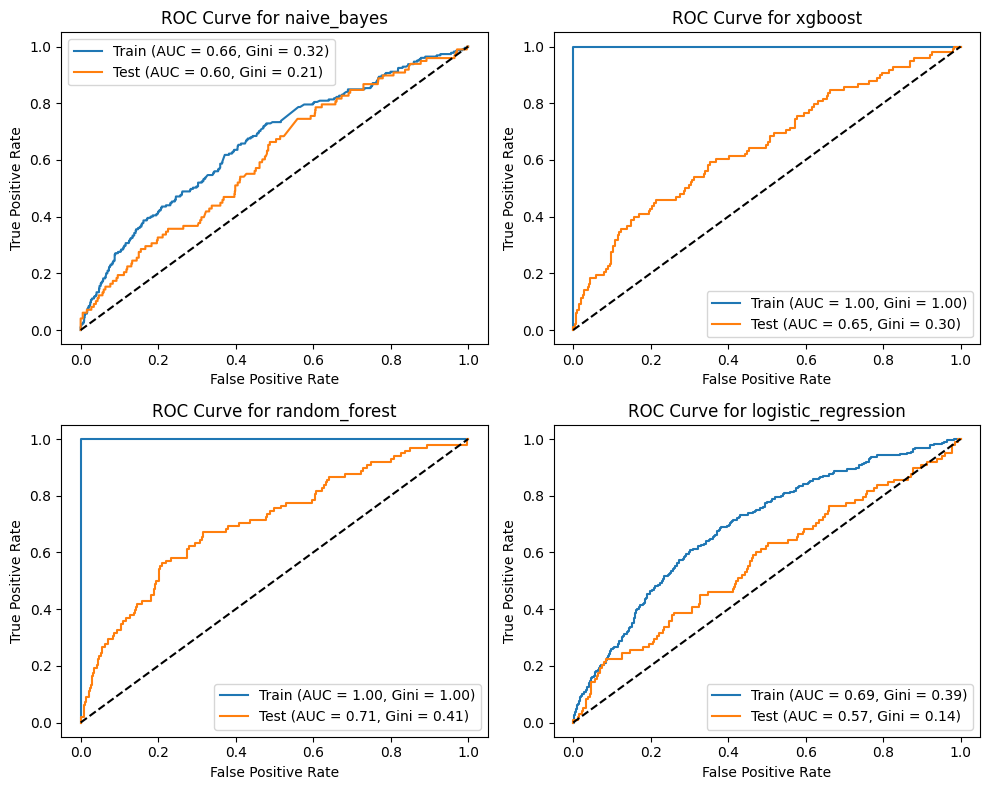

Features to keep: ['sum_MoneyRemittance', 'sum_OtherIncome', 'avg6Months_OtherSubsidies']
Features to discard: ['avg6Months_MoneyRemittance', 'avg6Months_OtherIncome', 'count_OtherSubsidies', 'sum_OtherSubsidies']


In [32]:





preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled,  = preprocessor.get_split_data_with_upsample_and_scaling(0.7)

# Example usage
models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models=models, X_train=Xtrain, y_train=Ytrain, n_trials=100)
best_params, best_models = optimizer.run()

# Usage
# Assuming best_models, Xtrain, Ytrain, Xtest, Ytest, train_upsampled are predefined
evaluator = ModelEvaluator(Xtrain, Ytrain, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()


# Usage
# Assuming best_models, train_upsampled, and forforsta are predefined
feature_importance = FeatureImportance(train_upsampled, best_models, forforsta)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features = feature_importance.plot_importances()


## Filter away highly correlated features and take away the absolut worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
SelectionTwo = filtered_list[:30]

## Feature 100-150

[I 2024-05-21 16:31:44,007] A new study created in memory with name: no-name-75f2c5e1-504a-41fe-bf52-5cf31203ea79


[I 2024-05-21 16:31:44,009] A new study created in memory with name: no-name-1f7413f9-b065-413d-bb5c-a2209e97b1b2
[I 2024-05-21 16:31:44,010] A new study created in memory with name: no-name-a7928493-e11a-4885-b2bd-53e045a407b4
[I 2024-05-21 16:31:44,017] A new study created in memory with name: no-name-663e3dd6-c186-4457-bd74-3ac3d8a7709d
[I 2024-05-21 16:31:44,049] Trial 0 finished with value: 0.02293417284766371 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.02293417284766371.


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Ever90
0    2230
1    2230
Name: count, dtype: int64
Optimizing naive_bayes...
Optimizing xgboost...
Optimizing random_forest...
Optimizing logistic_regression...


[I 2024-05-21 16:31:44,382] Trial 1 finished with value: 0.16346146186142851 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.001122343705918146, 'binarize': 0.034123367130562084}. Best is trial 1 with value: 0.16346146186142851.
[I 2024-05-21 16:31:44,592] Trial 2 finished with value: 0.10857315250787021 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.0030486727403216196, 'binarize': 0.20644216266211082}. Best is trial 1 with value: 0.16346146186142851.
[I 2024-05-21 16:31:44,614] Trial 3 finished with value: 0.02293417284766371 and parameters: {'nb_type': 'gaussian'}. Best is trial 1 with value: 0.16346146186142851.
[I 2024-05-21 16:31:44,645] Trial 4 finished with value: 0.02293417284766371 and parameters: {'nb_type': 'gaussian'}. Best is trial 1 with value: 0.16346146186142851.
[I 2024-05-21 16:31:44,869] Trial 5 finished with value: 0.1251790356825826 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.3391123225995897, 'binarize': 0.2888579403237386}. Best is trial 1 with 

Early stopping triggered.
Best parameters for naive_bayes: {'nb_type': 'bernoulli', 'alpha': 0.05176916520522329, 'binarize': 0.00683378169636276}


[I 2024-05-21 16:31:46,422] Trial 0 finished with value: 0.8371514242953513 and parameters: {'n_estimators': 78, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8371514242953513.
[I 2024-05-21 16:31:47,699] Trial 0 finished with value: 0.9945267085175304 and parameters: {'n_estimators': 134, 'max_depth': 9, 'learning_rate': 0.050679552820113424}. Best is trial 0 with value: 0.9945267085175304.
[I 2024-05-21 16:31:48,405] Trial 1 finished with value: 0.9977222312436801 and parameters: {'n_estimators': 194, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9977222312436801.
[I 2024-05-21 16:31:49,250] Trial 1 finished with value: 0.9321602672392769 and parameters: {'n_estimators': 162, 'max_depth': 7, 'learning_rate': 0.01145853658958304}. Best is trial 0 with value: 0.9945267085175304.
[I 2024-05-21 16:31:50,358] Trial 2 finished with value: 0.9969503609657631 and parameters: {'n_estimators': 185,

Early stopping triggered.
Best parameters for random_forest: {'n_estimators': 143, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3}


[I 2024-05-21 16:32:10,651] Trial 14 finished with value: 0.9976531094770423 and parameters: {'n_estimators': 176, 'max_depth': 13, 'learning_rate': 0.24944762905921455}. Best is trial 11 with value: 0.9987168104415645.
[I 2024-05-21 16:32:12,609] Trial 15 finished with value: 0.9975565873454263 and parameters: {'n_estimators': 184, 'max_depth': 15, 'learning_rate': 0.07916896801273128}. Best is trial 11 with value: 0.9987168104415645.
[I 2024-05-21 16:32:12,896] Trial 16 finished with value: 0.9959979397964069 and parameters: {'n_estimators': 20, 'max_depth': 13, 'learning_rate': 0.14819542772492095}. Best is trial 11 with value: 0.9987168104415645.
[I 2024-05-21 16:32:13,751] Trial 17 finished with value: 0.997630190624279 and parameters: {'n_estimators': 154, 'max_depth': 10, 'learning_rate': 0.29922303481817064}. Best is trial 11 with value: 0.9987168104415645.
[I 2024-05-21 16:32:15,003] Trial 18 finished with value: 0.998639371663485 and parameters: {'n_estimators': 104, 'max_dep

Early stopping triggered.
Best parameters for xgboost: {'n_estimators': 198, 'max_depth': 15, 'learning_rate': 0.09096062347450402}


[I 2024-05-21 16:32:33,246] Trial 3 finished with value: 0.19775941627071428 and parameters: {'C': 5.989218417414409, 'solver': 'saga', 'penalty_saga': 'l1'}. Best is trial 0 with value: 0.1995455853741516.
[I 2024-05-21 16:32:46,853] Trial 4 finished with value: 0.1995636802304268 and parameters: {'C': 0.01867972595763495, 'solver': 'sag'}. Best is trial 4 with value: 0.1995636802304268.
[I 2024-05-21 16:32:48,092] Trial 5 finished with value: 0.20384849447581957 and parameters: {'C': 0.2740427779878788, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.20384849447581957.
[I 2024-05-21 16:32:49,749] Trial 6 finished with value: 0.20384849447581957 and parameters: {'C': 0.17324902336974152, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.20384849447581957.
[I 2024-05-21 16:32:50,965] Trial 7 finished with value: 0.20384849447581957 and parameters: {'C': 1.7875250245851357, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.20384849447581957.
[I 2024-05-21 16:33:04,479] Trial 8 finishe

Early stopping triggered.
Best parameters for logistic_regression: {'C': 0.2740427779878788, 'solver': 'lbfgs'}


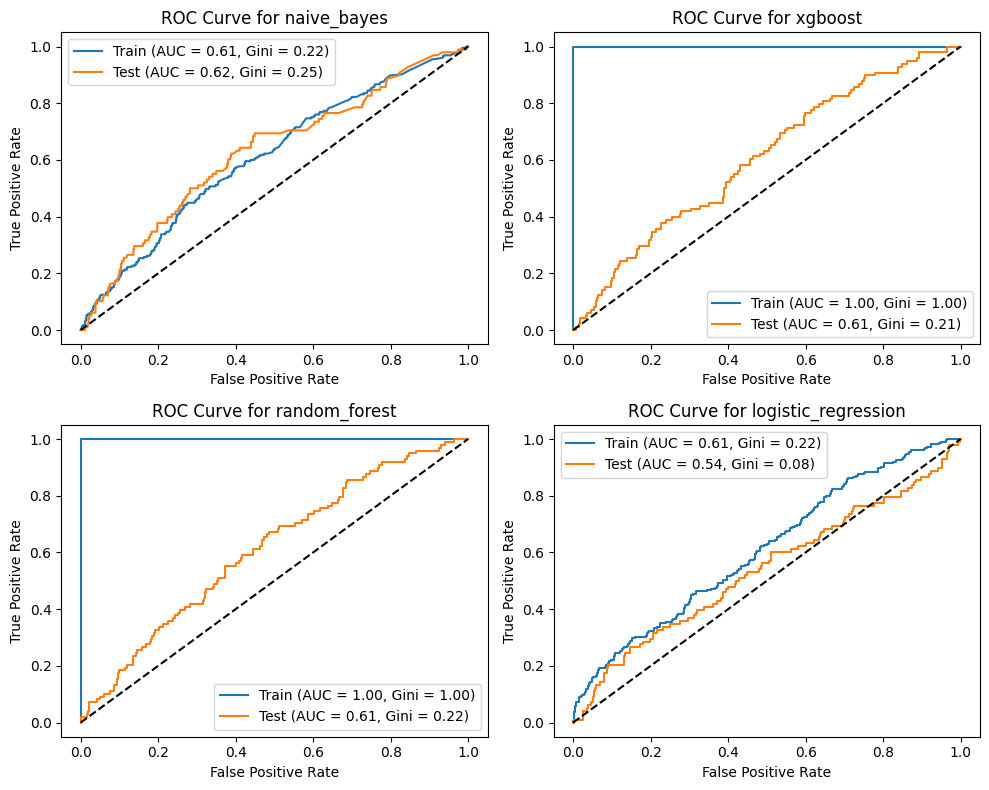

Features to keep: ['Gambling_sum12Months', 'Gambling_partOfSalary3Months', 'Gambling_partOfSalary9Months', 'Crypto_partOfSalary12Months', 'Crypto_sum12Months', 'Crypto_partOfSalary12Months', 'MoneyRemittance_count3Months', 'MoneyRemittance_monthlyAvg']
Features to discard: ['Gambling_monthlyAvg', 'Crypto_count12Months', 'Gambling_sum6Months', 'Crypto_count6Months', 'Crypto_count3Months', 'Crypto_count9Months', 'MoneyRemittance_category', 'MoneyRemittance_count12Months', 'Crypto_partOfSalary3Months', 'Crypto_sum6Months', 'Crypto_sum9Months', 'Crypto_monthlyAvg', 'Crypto_partOfSalary3Months', 'Crypto_sum6Months', 'MoneyRemittance_count6Months', 'MoneyRemittance_sum12Months']


In [11]:


# Keep the first feature (column)
first_feature = base.iloc[:, 0]

# Select columns from 50 to 100 (note: column index is 0-based, so 50-100 is 49-99)
selected_features = base.iloc[:, 100:150]

# Combine the first feature with the selected features
forforsta = pd.concat([first_feature, selected_features], axis=1)

forforsta



preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled,  = preprocessor.get_split_data_with_upsample_and_scaling(0.7)

# Example usage
models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models=models, X_train=Xtrain, y_train=Ytrain, n_trials=100)
best_params, best_models = optimizer.run()

# Usage
# Assuming best_models, Xtrain, Ytrain, Xtest, Ytest, train_upsampled are predefined
evaluator = ModelEvaluator(Xtrain, Ytrain, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()


# Usage
# Assuming best_models, train_upsampled, and forforsta are predefined
feature_importance = FeatureImportance(train_upsampled, best_models, forforsta)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features = feature_importance.plot_importances()


## Filter away highly correlated features and take away the absolut worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
selectionThree = filtered_list[:10]

## Features 150 - 200

[I 2024-05-21 16:33:09,347] A new study created in memory with name: no-name-517513dc-bf33-45c1-a1c8-b327476930aa
[I 2024-05-21 16:33:09,348] A new study created in memory with name: no-name-ee2c881f-4e97-49ff-a5ab-6d8658f3b898
[I 2024-05-21 16:33:09,348] A new study created in memory with name: no-name-d0e63b6f-f1f4-4201-bdef-0778f08cccbc
[I 2024-05-21 16:33:09,348] A new study created in memory with name: no-name-f614c44b-40dc-4827-b89c-90bd2124af14


[I 2024-05-21 16:33:09,471] Trial 0 finished with value: 0.1553355517743992 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.2616414607147021, 'binarize': 0.007314951509816271}. Best is trial 0 with value: 0.1553355517743992.
[I 2024-05-21 16:33:09,501] Trial 1 finished with value: 0.037805080201993135 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.1553355517743992.


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Ever90
0    2230
1    2230
Name: count, dtype: int64
Optimizing naive_bayes...
Optimizing xgboost...
Optimizing random_forest...
Optimizing logistic_regression...


[I 2024-05-21 16:33:09,780] Trial 0 finished with value: 0.2290833849608085 and parameters: {'C': 0.0023558505138751725, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 0 with value: 0.2290833849608085.
[I 2024-05-21 16:33:09,793] Trial 2 finished with value: 0.15328019327877565 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.00572489272424664, 'binarize': 0.10482129192563033}. Best is trial 0 with value: 0.1553355517743992.
[I 2024-05-21 16:33:09,816] Trial 3 finished with value: 0.037805080201993135 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.1553355517743992.
[I 2024-05-21 16:33:10,068] Trial 4 finished with value: 0.12439628463062184 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.0035230959334403415, 'binarize': 0.38543886487136475}. Best is trial 0 with value: 0.1553355517743992.
[I 2024-05-21 16:33:10,365] Trial 5 finished with value: 0.15226506096664796 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.4276191387550557, 'binarize': 0.

Early stopping triggered.
Best parameters for naive_bayes: {'nb_type': 'bernoulli', 'alpha': 0.2616414607147021, 'binarize': 0.007314951509816271}


[I 2024-05-21 16:33:12,059] Trial 0 finished with value: 0.914914882334967 and parameters: {'n_estimators': 99, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.914914882334967.
[I 2024-05-21 16:33:13,441] Trial 0 finished with value: 0.9770420098870373 and parameters: {'n_estimators': 199, 'max_depth': 7, 'learning_rate': 0.024217552463690672}. Best is trial 0 with value: 0.9770420098870373.
[I 2024-05-21 16:33:14,436] Trial 1 finished with value: 0.9984410521685613 and parameters: {'n_estimators': 73, 'max_depth': 8, 'learning_rate': 0.2787790546458826}. Best is trial 1 with value: 0.9984410521685613.
[I 2024-05-21 16:33:14,516] Trial 1 finished with value: 0.9928340441131821 and parameters: {'n_estimators': 154, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9928340441131821.
[I 2024-05-21 16:33:14,680] Trial 2 finished with value: 0.9883714302125707 and parameters: {'n_estimators': 22, 'ma

Early stopping triggered.
Best parameters for random_forest: {'n_estimators': 41, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1}


[I 2024-05-21 16:33:45,695] Trial 13 finished with value: 0.9994207243732603 and parameters: {'n_estimators': 196, 'max_depth': 15, 'learning_rate': 0.12597875922366994}. Best is trial 13 with value: 0.9994207243732603.
[I 2024-05-21 16:33:47,816] Trial 14 finished with value: 0.9981900761224698 and parameters: {'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.043507046248429396}. Best is trial 13 with value: 0.9994207243732603.
[I 2024-05-21 16:33:48,907] Trial 15 finished with value: 0.9986897736617856 and parameters: {'n_estimators': 99, 'max_depth': 13, 'learning_rate': 0.14888583719207388}. Best is trial 13 with value: 0.9994207243732603.
[I 2024-05-21 16:33:51,076] Trial 16 finished with value: 0.998850255948723 and parameters: {'n_estimators': 186, 'max_depth': 14, 'learning_rate': 0.08284509354080972}. Best is trial 13 with value: 0.9994207243732603.
[I 2024-05-21 16:33:51,382] Trial 19 finished with value: 0.3008419834634828 and parameters: {'C': 2.169136337711545, 'so

Early stopping triggered.
Best parameters for logistic_regression: {'C': 0.015799799780291095, 'solver': 'lbfgs'}


[I 2024-05-21 16:33:52,880] Trial 17 finished with value: 0.9991891936427569 and parameters: {'n_estimators': 143, 'max_depth': 11, 'learning_rate': 0.18120639999338695}. Best is trial 13 with value: 0.9994207243732603.
[I 2024-05-21 16:33:54,836] Trial 18 finished with value: 0.9985860642298837 and parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.05251412411793252}. Best is trial 13 with value: 0.9994207243732603.
[I 2024-05-21 16:33:56,269] Trial 19 finished with value: 0.9817574615847403 and parameters: {'n_estimators': 98, 'max_depth': 13, 'learning_rate': 0.011619625780773926}. Best is trial 13 with value: 0.9994207243732603.


Early stopping triggered.
Best parameters for xgboost: {'n_estimators': 196, 'max_depth': 15, 'learning_rate': 0.12597875922366994}


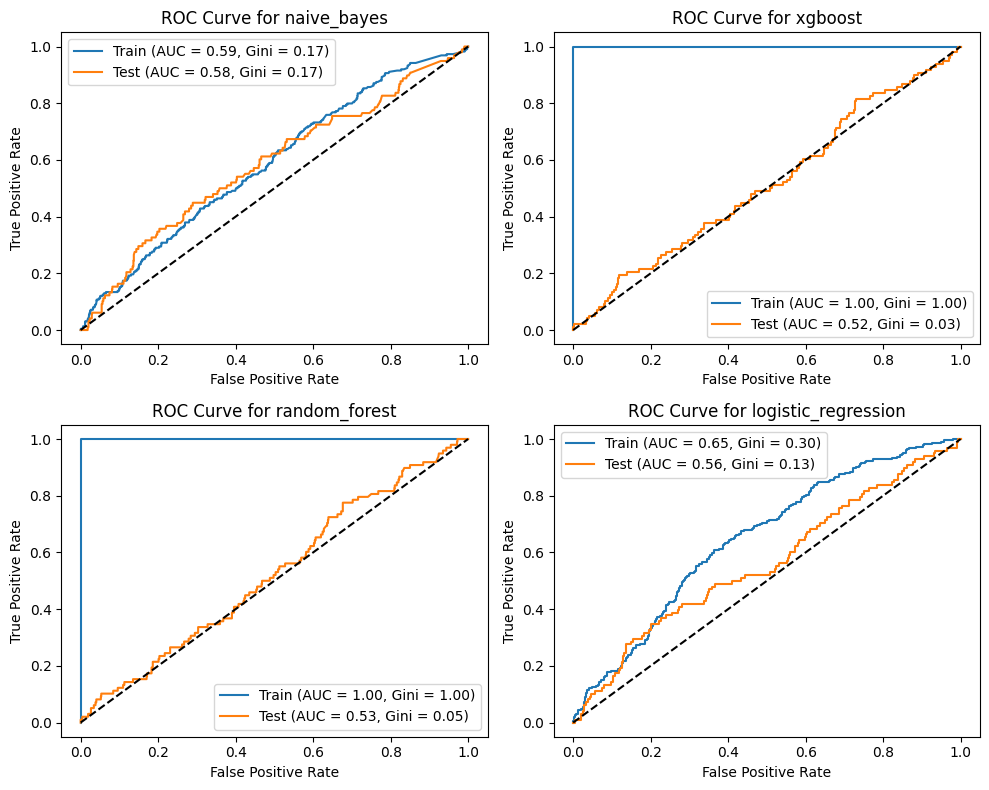

Features to keep: ['CashWithdrawal_count6Months', 'CashWithdrawal_monthlyAvg', 'CashWithdrawal_sum6Months', 'Gaming_count3Months', 'Gaming_monthlyAvg', 'Gaming_sum6Months', 'Gaming_partOfSalary9Months', 'MobilePayment_sum12Months', 'DebtCollection_count12Months', 'DebtCollection_category']
Features to discard: ['CashWithdrawal_count3Months', 'CashWithdrawal_sum12Months', 'CashWithdrawal_partOfSalary3Months', 'Gaming_count12Months', 'Gaming_count6Months', 'CashWithdrawal_partOfSalary9Months', 'Gaming_category', 'Gaming_sum12Months', 'Gaming_partOfSalary3Months', 'MobilePayment_count12Months', 'MobilePayment_count6Months', 'MobilePayment_count3Months', 'MobilePayment_sum9Months', 'MobilePayment_sum3Months', 'MobilePayment_monthlyAvg', 'MobilePayment_sum6Months', 'MobilePayment_partOfSalary3Months', 'DebtCollection_count3Months', 'DebtCollection_count6Months', 'MobilePayment_partOfSalary9Months']


In [12]:


# Keep the first feature (column)
first_feature = base.iloc[:, 0]

# Select columns from 50 to 100 (note: column index is 0-based, so 50-100 is 49-99)
selected_features = base.iloc[:, 150:200]

# Combine the first feature with the selected features
forforsta = pd.concat([first_feature, selected_features], axis=1)


preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled,  = preprocessor.get_split_data_with_upsample_and_scaling(0.7)

# Example usage
models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models=models, X_train=Xtrain, y_train=Ytrain, n_trials=100)
best_params, best_models = optimizer.run()

# Usage
# Assuming best_models, Xtrain, Ytrain, Xtest, Ytest, train_upsampled are predefined
evaluator = ModelEvaluator(Xtrain, Ytrain, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()


# Usage
# Assuming best_models, train_upsampled, and forforsta are predefined
feature_importance = FeatureImportance(train_upsampled, best_models, forforsta)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features = feature_importance.plot_importances()


## Filter away highly correlated features and take away the absolut worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
#selectionFour = filtered_list[:5]

## Features 200 - 270

[I 2024-05-21 16:33:59,225] A new study created in memory with name: no-name-ed1c22ab-771a-46cc-812a-04b5d5fc0691
[I 2024-05-21 16:33:59,233] A new study created in memory with name: no-name-3beb88b2-15bb-464d-8ea1-4e55e03ccb92
[I 2024-05-21 16:33:59,238] A new study created in memory with name: no-name-be078b4f-9e92-44a6-924e-ce0120d0c180
[I 2024-05-21 16:33:59,240] A new study created in memory with name: no-name-7bf42413-ed29-4f48-8683-4c3aabd0da9d
[I 2024-05-21 16:33:59,293] Trial 0 finished with value: 0.1658160826277492 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.1658160826277492.


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Ever90
0    2230
1    2230
Name: count, dtype: int64
Optimizing naive_bayes...
Optimizing xgboost...
Optimizing random_forest...
Optimizing logistic_regression...


[I 2024-05-21 16:33:59,452] Trial 1 finished with value: 0.19880912894393932 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.002350625557062037, 'binarize': 0.523063580694122}. Best is trial 1 with value: 0.19880912894393932.
[I 2024-05-21 16:33:59,607] Trial 2 finished with value: 0.17427421300993404 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.06585097759274373, 'binarize': 0.1547086493483465}. Best is trial 1 with value: 0.19880912894393932.
[I 2024-05-21 16:33:59,628] Trial 3 finished with value: 0.1658160826277492 and parameters: {'nb_type': 'gaussian'}. Best is trial 1 with value: 0.19880912894393932.
[I 2024-05-21 16:33:59,765] Trial 4 finished with value: 0.17496154485948937 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.03816003711346343, 'binarize': 0.21026718424159058}. Best is trial 1 with value: 0.19880912894393932.
[I 2024-05-21 16:33:59,794] Trial 5 finished with value: 0.1658160826277492 and parameters: {'nb_type': 'gaussian'}. Best is trial 1 with value

Early stopping triggered.
Best parameters for naive_bayes: {'nb_type': 'bernoulli', 'alpha': 0.20926500235186382, 'binarize': 0.8745153820904176}


[I 2024-05-21 16:34:02,265] Trial 0 finished with value: 0.9924429011031831 and parameters: {'n_estimators': 110, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9924429011031831.
[I 2024-05-21 16:34:04,090] Trial 0 finished with value: 0.9962960196036311 and parameters: {'n_estimators': 138, 'max_depth': 13, 'learning_rate': 0.02597494056768135}. Best is trial 0 with value: 0.9962960196036311.
[I 2024-05-21 16:34:05,092] Trial 1 finished with value: 0.9957318636024928 and parameters: {'n_estimators': 171, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9957318636024928.
[I 2024-05-21 16:34:06,129] Trial 1 finished with value: 0.9948999238555203 and parameters: {'n_estimators': 168, 'max_depth': 8, 'learning_rate': 0.04514637251668892}. Best is trial 0 with value: 0.9962960196036311.
[I 2024-05-21 16:34:06,710] Trial 2 finished with value: 0.9937388956778687 and parameters: {'n_estimators': 98

Early stopping triggered.
Best parameters for random_forest: {'n_estimators': 88, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1}


[I 2024-05-21 16:34:27,298] Trial 13 finished with value: 0.9973817012412493 and parameters: {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.14614618463543583}. Best is trial 13 with value: 0.9973817012412493.
[I 2024-05-21 16:34:28,438] Trial 14 finished with value: 0.9822490482524371 and parameters: {'n_estimators': 196, 'max_depth': 5, 'learning_rate': 0.048216577639922396}. Best is trial 13 with value: 0.9973817012412493.


Early stopping triggered.
Best parameters for xgboost: {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.14614618463543583}


[I 2024-05-21 16:34:38,052] Trial 1 finished with value: 0.312368007616279 and parameters: {'C': 0.0044115269346591225, 'solver': 'sag'}. Best is trial 0 with value: 0.31237644798698505.
[I 2024-05-21 16:34:41,105] Trial 2 finished with value: 0.31671730467071746 and parameters: {'C': 0.056037267381260344, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 2 with value: 0.31671730467071746.
[I 2024-05-21 16:35:02,428] Trial 3 finished with value: 0.3136244898940228 and parameters: {'C': 3.0163601069802315, 'solver': 'saga', 'penalty_saga': None}. Best is trial 2 with value: 0.31671730467071746.
[I 2024-05-21 16:35:20,637] Trial 4 finished with value: 0.31237163048308975 and parameters: {'C': 0.30335396399979175, 'solver': 'sag'}. Best is trial 2 with value: 0.31671730467071746.
[I 2024-05-21 16:35:41,799] Trial 5 finished with value: 0.31362448664772624 and parameters: {'C': 1.3063764684530466, 'solver': 'saga', 'penalty_saga': None}. Best is trial 2 with value: 0.31671730467071746

Early stopping triggered.
Best parameters for logistic_regression: {'C': 0.056037267381260344, 'solver': 'saga', 'penalty_saga': 'l2'}


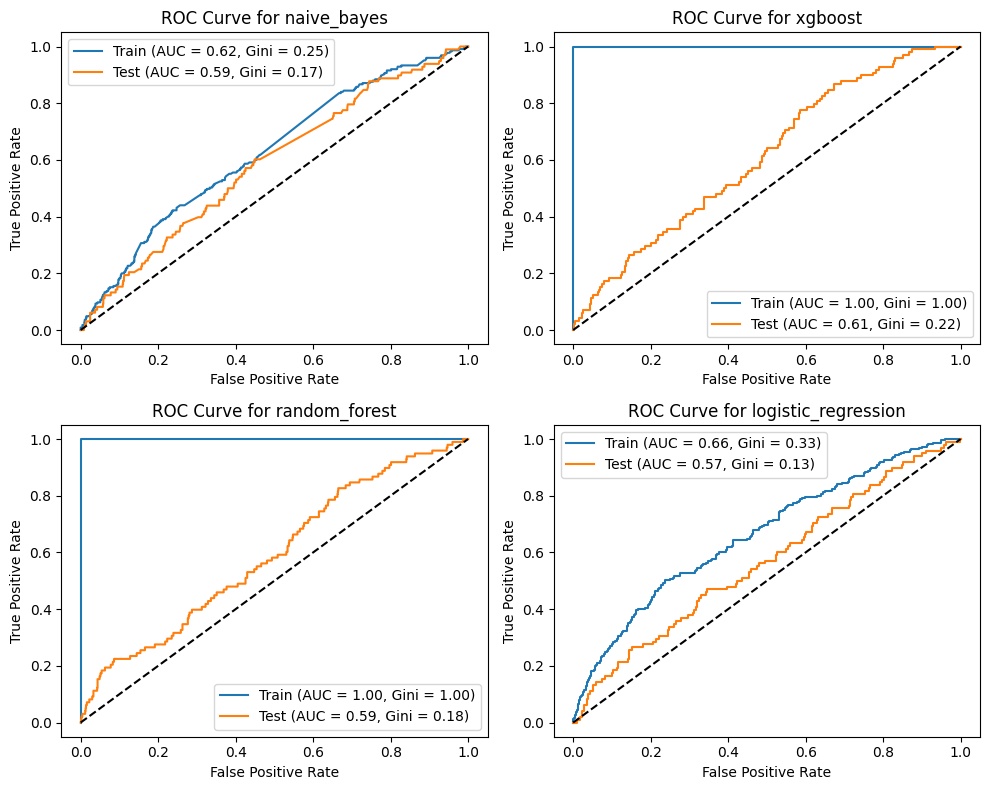

Features to keep: ['DebtCollection_sum12Months', 'DebtCollection_partOfSalary6Months', 'DebtCollection_partOfSalary9Months', 'InstallmentPayment_monthlyAvg', 'InstallmentPayment_partOfSalary12Months', 'HousingCost_count6Months', 'HousingCost_monthlyAvg', 'DirectDebit_count12Months', 'HousingCost_partOfSalary9Months', 'DirectDebit_sum3Months', 'Unclassified_count12Months', 'Unclassified_category', 'Unclassified_sum12Months', 'Unclassified_partOfSalary3Months', 'Unclassified_partOfSalary9Months']
Features to discard: ['DebtCollection_monthlyAvg', 'DebtCollection_partOfSalary12Months', 'InstallmentPayment_category', 'InstallmentPayment_count6Months', 'InstallmentPayment_count3Months', 'InstallmentPayment_sum12Months', 'Unclassified_partOfSalary12Months', 'HousingCost_count3Months', 'InstallmentPayment_partOfSalary9Months', 'HousingCost_sum12Months', 'HousingCost_partOfSalary3Months', 'HousingCost_sum6Months', 'DirectDebit_category', 'HousingCost_sum9Months', 'DirectDebit_count3Months', 'D

In [13]:


# Keep the first feature (column)
first_feature = base.iloc[:, 0]

# Select columns from 50 to 100 (note: column index is 0-based, so 50-100 is 49-99)
selected_features = base.iloc[:, 200:270]

# Combine the first feature with the selected features
forforsta = pd.concat([first_feature, selected_features], axis=1)


preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled,  = preprocessor.get_split_data_with_upsample_and_scaling(0.7)

# Example usage
models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models=models, X_train=Xtrain, y_train=Ytrain, n_trials=100)
best_params, best_models = optimizer.run()

# Usage
# Assuming best_models, Xtrain, Ytrain, Xtest, Ytest, train_upsampled are predefined
evaluator = ModelEvaluator(Xtrain, Ytrain, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()


# Usage
# Assuming best_models, train_upsampled, and forforsta are predefined
feature_importance = FeatureImportance(train_upsampled, best_models, forforsta)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features = feature_importance.plot_importances()


## Filter away highly correlated features and take away the absolut worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
selectionFive = filtered_list[:15]

## FIRST DONE

## Now lets take the best of each and do it again! - 2 Data Splits

In [38]:

filtereddf =  base[['Ever90']+ SelectionOne+SelectionTwo+selectionThree + selectionFive]


# Keep the first feature (column)
first_feature = filtereddf.iloc[:, 0]

# # Select columns from 50 to 100 (note: column index is 0-based, so 50-100 is 49-99)
selected_features = filtereddf.iloc[:,1 :50]

# Combine the first feature with the selected features
selected_features = pd.concat([first_feature, selected_features], axis=1)


[I 2024-05-21 16:55:08,068] A new study created in memory with name: no-name-7e494073-61a1-4e12-9544-78a29590e2ca
[I 2024-05-21 16:55:08,069] A new study created in memory with name: no-name-0304b747-6a3a-449a-929a-98962eabeda8
[I 2024-05-21 16:55:08,069] A new study created in memory with name: no-name-98ad92fe-d616-470e-b95c-33d775094310
[I 2024-05-21 16:55:08,069] A new study created in memory with name: no-name-6ab17aa7-44a8-4c97-b17d-ce2de8925a9f


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Ever90
0    2230
1    2230
Name: count, dtype: int64
Optimizing naive_bayes...
Optimizing xgboost...
Optimizing random_forest...
Optimizing logistic_regression...


[I 2024-05-21 16:55:08,424] Trial 0 finished with value: 0.2945414366397829 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.018081381269760107, 'binarize': 0.008393651726414821}. Best is trial 0 with value: 0.2945414366397829.
[I 2024-05-21 16:55:08,772] Trial 1 finished with value: 0.29638642457657793 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.04410799580145562, 'binarize': 0.08814620337023775}. Best is trial 1 with value: 0.29638642457657793.
[I 2024-05-21 16:55:09,059] Trial 2 finished with value: 0.3005589226466709 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.6449166218986033, 'binarize': 0.05041849939074688}. Best is trial 2 with value: 0.3005589226466709.
[I 2024-05-21 16:55:09,355] Trial 3 finished with value: 0.293364266253156 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.14163075582969056, 'binarize': 0.0040115271155514816}. Best is trial 2 with value: 0.3005589226466709.
[I 2024-05-21 16:55:09,662] Trial 4 finished with value: 0.29810470469444517 and

Early stopping triggered.
Best parameters for naive_bayes: {'nb_type': 'bernoulli', 'alpha': 0.20639080304799173, 'binarize': 0.39869771553494165}


[I 2024-05-21 16:55:11,563] Trial 0 finished with value: 0.3846039382990461 and parameters: {'C': 0.07666043244419295, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.3846039382990461.
[I 2024-05-21 16:55:12,511] Trial 0 finished with value: 0.9756351153338675 and parameters: {'n_estimators': 197, 'max_depth': 3, 'learning_rate': 0.11649977752517111}. Best is trial 0 with value: 0.9756351153338675.
[I 2024-05-21 16:55:13,270] Trial 1 finished with value: 0.9979063790315584 and parameters: {'n_estimators': 41, 'max_depth': 9, 'learning_rate': 0.20429780955420646}. Best is trial 1 with value: 0.9979063790315584.
[I 2024-05-21 16:55:13,710] Trial 0 finished with value: 0.9965925817672762 and parameters: {'n_estimators': 196, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9965925817672762.
[I 2024-05-21 16:55:14,265] Trial 2 finished with value: 0.998738518425761 and parameters: {'n_estimators': 66, 'max_depth': 9, 'learning_rate': 0.122156

Early stopping triggered.
Best parameters for xgboost: {'n_estimators': 82, 'max_depth': 15, 'learning_rate': 0.04374943868768322}


[I 2024-05-21 16:55:34,993] Trial 14 finished with value: 0.9960992469689541 and parameters: {'n_estimators': 127, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9978756950377456.
[I 2024-05-21 16:55:36,079] Trial 15 finished with value: 0.9932018186583628 and parameters: {'n_estimators': 79, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9978756950377456.
[I 2024-05-21 16:55:36,775] Trial 16 finished with value: 0.997213945627171 and parameters: {'n_estimators': 46, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9978756950377456.
[I 2024-05-21 16:55:37,473] Trial 3 finished with value: 0.38458722636504833 and parameters: {'C': 0.2878424853081006, 'solver': 'saga', 'penalty_saga': None}. Best is trial 0 with value: 0.3846039382990461.
[I 2024-05-21 16:55:37,612] Trial 4 finished with value: 0.37888944699217025 and parameters: {'C': 0.0343227441

Early stopping triggered.
Best parameters for random_forest: {'n_estimators': 76, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 4}


[I 2024-05-21 16:55:50,173] Trial 7 finished with value: 0.38458722636504833 and parameters: {'C': 33.75919402495434, 'solver': 'saga', 'penalty_saga': None}. Best is trial 0 with value: 0.3846039382990461.
[I 2024-05-21 16:56:02,619] Trial 8 finished with value: 0.3845860203659263 and parameters: {'C': 0.1461562686560649, 'solver': 'saga', 'penalty_saga': None}. Best is trial 0 with value: 0.3846039382990461.
[I 2024-05-21 16:56:12,598] Trial 9 finished with value: 0.384617778883856 and parameters: {'C': 1.604126329523304, 'solver': 'sag'}. Best is trial 9 with value: 0.384617778883856.
[I 2024-05-21 16:56:22,712] Trial 10 finished with value: 0.3846226028803441 and parameters: {'C': 2.8195286149815946, 'solver': 'sag'}. Best is trial 10 with value: 0.3846226028803441.
[I 2024-05-21 16:56:32,871] Trial 11 finished with value: 0.3846262257471548 and parameters: {'C': 2.1603004115726936, 'solver': 'sag'}. Best is trial 11 with value: 0.3846262257471548.
[I 2024-05-21 16:56:42,866] Trial

Early stopping triggered.
Best parameters for logistic_regression: {'C': 2.1603004115726936, 'solver': 'sag'}


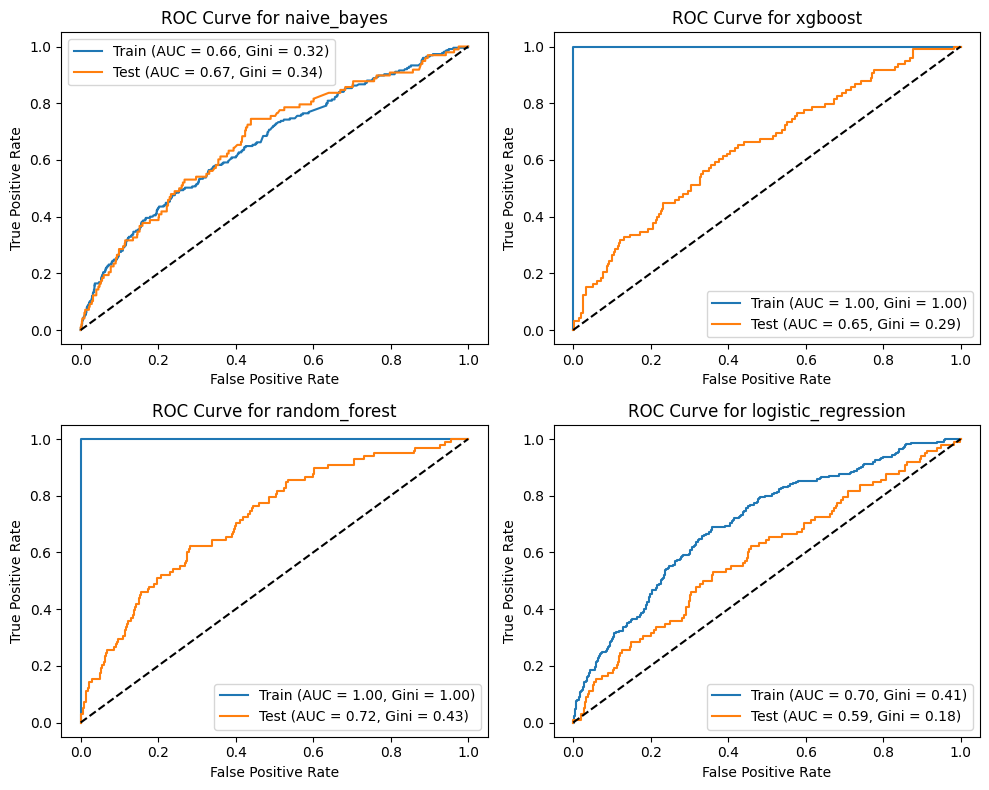

Features to keep: ['sum_DirectDebit', 'sum_Salary', 'sum_Loan', 'sum_OtherIncome', 'sum_InstallmentPayment', 'avg_OtherSubsidies']
Features to discard: ['avg6Months_DirectDebit', 'avg_Salary', 'avg_Loan', 'avg_OtherIncome', 'avg_InstallmentPayment', 'avg3Months_OtherSubsidies', 'avg6Months_OtherSubsidies']


In [39]:

preprocessor = DataPreprocessor(selected_features)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled,  = preprocessor.get_split_data_with_upsample_and_scaling(0.7)

# Example usage
models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models=models, X_train=Xtrain, y_train=Ytrain, n_trials=100)
best_params, best_models = optimizer.run()

# Usage
# Assuming best_models, Xtrain, Ytrain, Xtest, Ytest, train_upsampled are predefined
evaluator = ModelEvaluator(Xtrain, Ytrain, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()


# Usage
# Assuming best_models, train_upsampled, and selected_features are predefined
feature_importance = FeatureImportance(train_upsampled, best_models, selected_features)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features = feature_importance.plot_importances()


## Filter away highly correlated features and take away the absolut worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
selection2x1 = filtered_list[:30]

## Split 2

In [40]:

filtereddf =  base[['Ever90']+ SelectionOne+SelectionTwo+selectionThree + selectionFive]


# Keep the first feature (column)
first_feature = filtereddf.iloc[:, 0]

# # Select columns from 50 to 100 (note: column index is 0-based, so 50-100 is 49-99)
selected_features = filtereddf.iloc[:, 50:]

# Combine the first feature with the selected features
selected_features = pd.concat([first_feature, selected_features], axis=1)

In [41]:
selected_features

,Ever90,avg6Months_Salary,sum_Gaming,trend_HousingCost,sum_CashWithdrawal,sum_DebtCollection,count_PassiveIncome,sum_MobilePayment,sum_Deposit,count_Crypto,...,Unclassified_count12Months,HousingCost_count6Months,Unclassified_sum3Months,DirectDebit_count12Months,DebtCollection_sum12Months,DirectDebit_count9Months,Unclassified_category,DebtCollection_partOfSalary6Months,Unclassified_count9Months,DebtCollection_partOfSalary3Months
0,1,19471,276,90.6,10,13226,0,20086,16161,0,...,0,87381,248.5,7560,3.3,0,0,10.0,0,7.0
1,1,24828,21006,0.0,22322,11696,0,631221,49254,0,...,0,0,1553.4,0,8.7,0,0,5.4,285,899.0
2,1,23030,0,0.0,108600,22603,1,184827,256736,0,...,0,68903,415.5,0,8.1,0,0,6.0,0,3.0
3,1,19008,540,0.0,40400,13387,0,217670,21034,0,...,0,2,439.5,9022,8.0,0,0,6.6,95,956.0
4,1,28640,608,100.0,38,32720,0,108528,14895,0,...,1809,1,251386.0,0,32722.0,0,0,6.1,1361,7.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,0,13959,275,56.6,18162,32109,9,96399,45876,0,...,903,5,84024.0,0,31610.0,0,0,10.8,638,0.0
3489,0,22774,415,-100.0,16000,204818,1,35390,20095,0,...,801,1,91087.0,0,198731.0,0,0,88.0,629,33.2
3490,0,31358,620,0.0,350,46267,0,60395,23094,0,...,0,78021,135.9,0,12.9,0,0,16.0,0,13.0
3491,0,45633,468,0.0,0,0,3,64587,13805,0,...,3407,213462,76.7,0,0.0,0,9656,0.0,0,0.0


[I 2024-05-21 16:58:54,063] A new study created in memory with name: no-name-2eda23be-4bbe-4638-bb61-2651b80bc224
[I 2024-05-21 16:58:54,069] A new study created in memory with name: no-name-8d30b39b-9353-425f-a3b3-4e78e82b679b


[I 2024-05-21 16:58:54,070] A new study created in memory with name: no-name-10a68b27-8dc6-4e48-9ac7-ba8b95be2976
[I 2024-05-21 16:58:54,070] A new study created in memory with name: no-name-8a736aa9-8502-41ae-99fc-270bf81d93b6
[I 2024-05-21 16:58:54,121] Trial 0 finished with value: 0.11029522267681406 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.11029522267681406.
[I 2024-05-21 16:58:54,136] Trial 1 finished with value: 0.11029522267681406 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.11029522267681406.
[I 2024-05-21 16:58:54,145] Trial 2 finished with value: 0.11029522267681406 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.11029522267681406.
[I 2024-05-21 16:58:54,156] Trial 3 finished with value: 0.11029522267681406 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.11029522267681406.
[I 2024-05-21 16:58:54,166] Trial 4 finished with value: 0.11029522267681406 and parameters: {'nb_type':

Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Ever90
0    2230
1    2230
Name: count, dtype: int64
Optimizing naive_bayes...
Optimizing xgboost...
Optimizing random_forest...
Optimizing logistic_regression...
Early stopping triggered.
Best parameters for naive_bayes: {'nb_type': 'bernoulli', 'alpha': 0.004759572392792416, 'binarize': 0.003101317406930539}


[I 2024-05-21 16:58:56,229] Trial 0 finished with value: 0.25805229544613884 and parameters: {'C': 0.4919450884375571, 'solver': 'saga', 'penalty_saga': None}. Best is trial 0 with value: 0.25805229544613884.
[I 2024-05-21 16:58:56,313] Trial 1 finished with value: 0.25633542016304967 and parameters: {'C': 0.08469594353831533, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 0 with value: 0.25805229544613884.
[I 2024-05-21 16:58:56,581] Trial 0 finished with value: 0.9964666741604175 and parameters: {'n_estimators': 141, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9964666741604175.
[I 2024-05-21 16:58:57,340] Trial 0 finished with value: 0.9983790755003561 and parameters: {'n_estimators': 184, 'max_depth': 8, 'learning_rate': 0.0659211074023814}. Best is trial 0 with value: 0.9983790755003561.
[I 2024-05-21 16:58:57,985] Trial 1 finished with value: 0.7703551047696399 and parameters: {'n_estimators': 153, 'max_depth': 5

Early stopping triggered.
Best parameters for logistic_regression: {'C': 0.4919450884375571, 'solver': 'saga', 'penalty_saga': None}


[I 2024-05-21 16:59:12,147] Trial 9 finished with value: 0.9977073307430874 and parameters: {'n_estimators': 190, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.998216238025362.
[I 2024-05-21 16:59:12,324] Trial 5 finished with value: 0.9708858274885226 and parameters: {'n_estimators': 108, 'max_depth': 9, 'learning_rate': 0.01044927426172021}. Best is trial 2 with value: 0.9984466601456363.
[I 2024-05-21 16:59:12,430] Trial 10 finished with value: 0.9978915304717088 and parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.998216238025362.


Early stopping triggered.
Best parameters for random_forest: {'n_estimators': 43, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1}


[I 2024-05-21 16:59:12,912] Trial 6 finished with value: 0.999073740733536 and parameters: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.23863170709090278}. Best is trial 6 with value: 0.999073740733536.
[I 2024-05-21 16:59:13,272] Trial 7 finished with value: 0.7770731480377199 and parameters: {'n_estimators': 135, 'max_depth': 4, 'learning_rate': 0.018660842638909984}. Best is trial 6 with value: 0.999073740733536.
[I 2024-05-21 16:59:14,225] Trial 8 finished with value: 0.9947788305062604 and parameters: {'n_estimators': 114, 'max_depth': 9, 'learning_rate': 0.024049341406340508}. Best is trial 6 with value: 0.999073740733536.
[I 2024-05-21 16:59:16,097] Trial 9 finished with value: 0.9975166903623581 and parameters: {'n_estimators': 173, 'max_depth': 12, 'learning_rate': 0.03260116508921723}. Best is trial 6 with value: 0.999073740733536.
[I 2024-05-21 16:59:16,182] Trial 10 finished with value: 0.8959039650335958 and parameters: {'n_estimators': 24, 'max_depth': 4, 'lea

Early stopping triggered.
Best parameters for xgboost: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.23863170709090278}


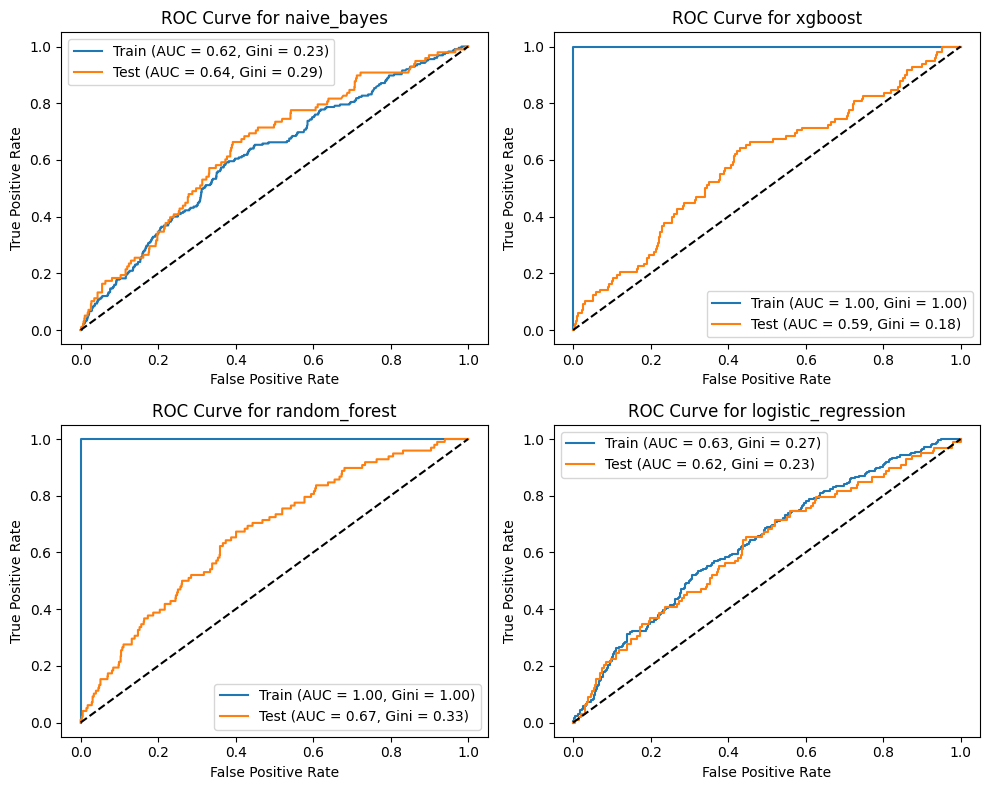

Features to keep: ['sum_HousingCost']
Features to discard: ['DirectDebit_count12Months']


In [42]:

preprocessor = DataPreprocessor(selected_features)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled,  = preprocessor.get_split_data_with_upsample_and_scaling(0.7)

# Example usage
models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models=models, X_train=Xtrain, y_train=Ytrain, n_trials=100)
best_params, best_models = optimizer.run()

# Usage
# Assuming best_models, Xtrain, Ytrain, Xtest, Ytest, train_upsampled are predefined
evaluator = ModelEvaluator(Xtrain, Ytrain, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()


# Usage
# Assuming best_models, train_upsampled, and selected_features are predefined
feature_importance = FeatureImportance(train_upsampled, best_models, selected_features)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()


features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features = feature_importance.plot_importances()


## Filter away highly correlated features and take away the absolut worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
selection2x2 = filtered_list[:30]

## Split 3 

In [43]:

filtereddf =  base[['Ever90']+selection2x1 + selection2x2]


# Keep the first feature (column)
first_feature = filtereddf.iloc[:, 0]

# # Select columns from 50 to 100 (note: column index is 0-based, so 50-100 is 49-99)
selected_features = filtereddf.iloc[:, 50:]

# Combine the first feature with the selected features
selected_features = pd.concat([first_feature, selected_features], axis=1)

[I 2024-05-21 16:59:45,934] A new study created in memory with name: no-name-cf958388-93e2-4938-b4ad-20ad88d91a5d
[I 2024-05-21 16:59:45,934] A new study created in memory with name: no-name-2efa009a-c659-4191-9682-ca72b5eecd94
[I 2024-05-21 16:59:45,934] A new study created in memory with name: no-name-df7fc4ee-c52d-4b5f-8b44-9a45f547b115
[I 2024-05-21 16:59:45,934] A new study created in memory with name: no-name-48b8121a-aa22-49b3-9caf-e7802857160d
[I 2024-05-21 16:59:45,979] Trial 0 finished with value: 0.0026013831196519677 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.0026013831196519677.
[I 2024-05-21 16:59:46,023] Trial 0 finished with value: 0.10876336437747132 and parameters: {'C': 0.001624347836131038, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 0 with value: 0.10876336437747132.
[I 2024-05-21 16:59:46,050] Trial 1 finished with value: 0.0026013831196519677 and parameters: {'nb_type': 'gaussian'}. Best is trial 0 with value: 0.00

Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Ever90
0    2230
1    2230
Name: count, dtype: int64
Optimizing naive_bayes...
Optimizing xgboost...
Optimizing random_forest...
Optimizing logistic_regression...


[I 2024-05-21 16:59:46,137] Trial 4 finished with value: 0.0026013831196519677 and parameters: {'nb_type': 'gaussian'}. Best is trial 3 with value: 0.1234400101074089.
[I 2024-05-21 16:59:46,161] Trial 5 finished with value: 0.0026013831196519677 and parameters: {'nb_type': 'gaussian'}. Best is trial 3 with value: 0.1234400101074089.
[I 2024-05-21 16:59:46,189] Trial 6 finished with value: 0.0026013831196519677 and parameters: {'nb_type': 'gaussian'}. Best is trial 3 with value: 0.1234400101074089.
[I 2024-05-21 16:59:46,207] Trial 7 finished with value: 0.0026013831196519677 and parameters: {'nb_type': 'gaussian'}. Best is trial 3 with value: 0.1234400101074089.
[I 2024-05-21 16:59:46,233] Trial 8 finished with value: 0.14731066562055414 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.21124540632019684, 'binarize': 0.0013879282694080762}. Best is trial 8 with value: 0.14731066562055414.
[I 2024-05-21 16:59:46,263] Trial 9 finished with value: 0.0026013831196519677 and parameters: 

Early stopping triggered.
Best parameters for naive_bayes: {'nb_type': 'bernoulli', 'alpha': 0.21124540632019684, 'binarize': 0.0013879282694080762}


[I 2024-05-21 16:59:46,589] Trial 3 finished with value: 0.1114166906746518 and parameters: {'C': 0.013853997033271946, 'solver': 'saga', 'penalty_saga': None}. Best is trial 1 with value: 0.11241134453735417.
[I 2024-05-21 16:59:46,727] Trial 4 finished with value: 0.11140590323163028 and parameters: {'C': 0.06272408804595322, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.11241134453735417.
[I 2024-05-21 16:59:46,804] Trial 5 finished with value: 0.11140590323163028 and parameters: {'C': 0.6361188187542349, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.11241134453735417.
[I 2024-05-21 16:59:46,939] Trial 6 finished with value: 0.11140590323163028 and parameters: {'C': 0.03281786716910119, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.11241134453735417.
[I 2024-05-21 16:59:47,092] Trial 7 finished with value: 0.11144202801825205 and parameters: {'C': 0.0054195338332760625, 'solver': 'sag'}. Best is trial 1 with value: 0.11241134453735417.
[I 2024-05-21 16:59:47,171] Trial 8

Early stopping triggered.
Best parameters for logistic_regression: {'C': 0.030009818389590635, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}


[I 2024-05-21 16:59:47,910] Trial 0 finished with value: 0.6456821675113497 and parameters: {'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.03666537684275932}. Best is trial 0 with value: 0.6456821675113497.
[I 2024-05-21 16:59:48,083] Trial 0 finished with value: 0.9833669047455017 and parameters: {'n_estimators': 188, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9833669047455017.
[I 2024-05-21 16:59:48,438] Trial 1 finished with value: 0.9707045064132567 and parameters: {'n_estimators': 50, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9833669047455017.
[I 2024-05-21 16:59:49,078] Trial 2 finished with value: 0.9081024554330409 and parameters: {'n_estimators': 107, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9833669047455017.
[I 2024-05-21 16:59:49,329] Trial 1 finished with value: 0.9875806656778838 and parameters: {'n_estimato

Early stopping triggered.
Best parameters for random_forest: {'n_estimators': 80, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2}


[I 2024-05-21 16:59:56,649] Trial 12 finished with value: 0.9972845257924777 and parameters: {'n_estimators': 147, 'max_depth': 12, 'learning_rate': 0.08846558321520957}. Best is trial 8 with value: 0.9979069235977839.
[I 2024-05-21 16:59:57,869] Trial 13 finished with value: 0.9982976738059154 and parameters: {'n_estimators': 173, 'max_depth': 13, 'learning_rate': 0.09385537097631647}. Best is trial 13 with value: 0.9982976738059154.
[I 2024-05-21 16:59:59,189] Trial 14 finished with value: 0.9971917141776757 and parameters: {'n_estimators': 162, 'max_depth': 14, 'learning_rate': 0.07271448442820067}. Best is trial 13 with value: 0.9982976738059154.
[I 2024-05-21 16:59:59,700] Trial 15 finished with value: 0.9956776366554289 and parameters: {'n_estimators': 88, 'max_depth': 10, 'learning_rate': 0.12422863765754731}. Best is trial 13 with value: 0.9982976738059154.
[I 2024-05-21 17:00:00,959] Trial 16 finished with value: 0.9974389456208405 and parameters: {'n_estimators': 172, 'max_de

Early stopping triggered.
Best parameters for xgboost: {'n_estimators': 173, 'max_depth': 13, 'learning_rate': 0.09385537097631647}


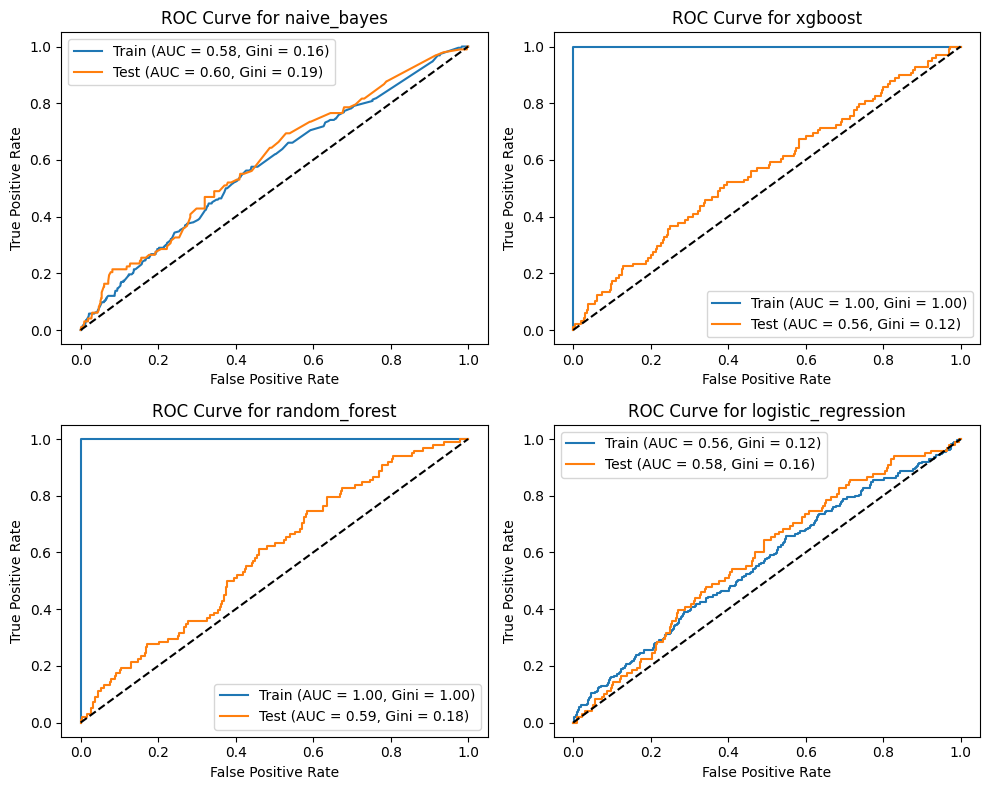

Features to keep: []
Features to discard: []


In [44]:

preprocessor = DataPreprocessor(selected_features)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled,  = preprocessor.get_split_data_with_upsample_and_scaling(0.7)

# Example usage
models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models=models, X_train=Xtrain, y_train=Ytrain, n_trials=100)
best_params, best_models = optimizer.run()

# Usage
# Assuming best_models, Xtrain, Ytrain, Xtest, Ytest, train_upsampled are predefined
evaluator = ModelEvaluator(Xtrain, Ytrain, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()


# Usage
# Assuming best_models, train_upsampled, and selected_features are predefined
feature_importance = FeatureImportance(train_upsampled, best_models, selected_features)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features = feature_importance.plot_importances()


## Filter away highly correlated features and take away the absolut worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
#selection2x2 = filtered_list[:30]